TP 4 - Echantillonnage compressif
==================

In [6]:
import numpy as np
import math
import scipy.fftpack as fft
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

Récemment (début années 2004-présent), de nouveaux concepts et théorèmes ont été développés et risquent de 
révolutionner à relativement court terme la fabrication de certains appareils de mesure numériques (microphones, imageurs, analyseurs de spectres,...). 
Ces nouvelles techniques sont couramment appelées échantillonnage compressif, "compressive sampling" ou encore "compressed sensing". 
Nous les décrivons rapidement ci-après. Vous trouverez un tutoriel bien plus complet (sous forme de présentation) à l'adresse http://users.ece.gatech.edu/~justin/ssp2007/ssp07-cs-tutorial.pdf

## 1. Le théorème de Shannon

Aujourd'hui, presque tous les appareils de mesure reposent sur le théorème de Shannon. Celui-ci (vous l'avez déjà vu en 2ème année) peut s'énoncer ainsi : 
<div style="background-color:rgba(0, 0, 255, 0.1); padding:15px;">
    Soit $g:\mathbb{R}\to \mathbb{R}$ une fonction de $L^2(\mathbb{R})$. Si sa transformée de Fourier $\hat g$ a un support contenu dans l'intervalle $[-f_M, f_M]$, alors en l'échantillonnant à une fréquence d'échantillonnage $f_e\geq 2f_M$, on peut la reconstruire exactement.
</div>

Ce théorème est illustré sur les figures ci-après:

In [7]:
from Shannon import shannon
shannon()

ModuleNotFoundError: No module named 'Shannon'

Les instruments de mesures qui reposent sur ce théorème sont donc construits suivant le principe : 
<div style="background-color:rgba(0, 0, 0, 0.1); padding:15px;">
Filtre passe-bas $\rightarrow$ Echantillonnage à une fréquence $f>2f_M$ $\rightarrow$ Interpolation sinc
</div>
Pour beaucoup d'applications, ce principe présente deux défauts majeurs :

* Les signaux sont rarement naturellement à spectre borné, et on perd donc l'information haute-fréquence en effectuant un filtrage passe-bas.
* Pour beaucoup de signaux, il faut choisir une très haute fréquence d'échantillonnage pour obtenir un résultat satisfaisant. 
Ceci implique que les données à stocker ont une taille très importante et qu'il faut les compresser après coup (par exemple : jpeg).

## 2. L'échantillonnage compressif

### 2.1 Principe général

L'idée sous jacente à l'échantillonnage compressif est de réaliser la compression dès l'acquisition.
Supposons que le signal $x\in \mathbb{R}^n$ que l'on souhaite mesurer s'écrive comme une combinaison linéaire de la forme :
\begin{equation}
(1)~~~~~~~~~~~ x=\sum_{i=1}^m\alpha_i \psi_i
\end{equation}
où $\psi_i\in \mathbb{R}^n, \ i=1..m$, sont des "fonctions de base" (en traitement d'images, ces fonctions pourraient être des ondelettes, en traitement du son, des ondelettes ou des atomes de Fourier, pour certaines applications, on pourrait imaginer des splines...} et $\alpha_i\in \mathbb{R}$ sont des coefficients. 
On peut réécrire l'équation (1) sous la forme matricielle condensée :
$$
x=\Psi \alpha \ \ \textrm{où } \ \ \alpha=\begin{pmatrix} \alpha_1 \\ \vdots \\ \alpha_m \end{pmatrix}\ \ \textrm{et} \ \ \Psi=\begin{pmatrix} \psi_1,\psi_2,..., \psi_m\end{pmatrix}.
$$
Pour pouvoir reconstruire tous les éléments de $\mathbb{R}^n$, on suppose généralement que la matrice $\Psi$ est une matrice surjective (ainsi, la famille  des $(\Psi_i)_i$ est génératrice), ce qui implique que $m\geq n$. Dans le langage du traitement d'image, on dit alors que $\Psi$ est un frame (une base si $m=n$).

L'échantillonnage compressif repose sur l'hypothèse suivante : les signaux $x$ que l'on souhaite mesurer sont parcimonieux, 
c'est-à-dire que la majorité des coefficients $\alpha_i$ dans (1) sont nuls ou encore que 
$$\#\{\alpha_i\neq 0, i=1..m\}\ll n.$$
On va voir que cette hypothèse permet - dans certains cas - de réduire drastiquement le nombre de mesures par rapport au théorème de Shannon avec en contre-partie, le besoin de résoudre un problème d'optimisation pour reconstruire la donnée. L'objectif de ce TP est de résoudre le problème d'optimisation résultant.

Le principe de l'acquisition du signal $x$ est le suivant :

- On effectue un petit nombre $p\ll n$ de mesures linéaires du signal $x$ inconnu. On note ces mesures $y_i$, et comme elles sont linéaires par rapport à $x$, il existe pour chaque $i$ un vecteur $a_i\in \mathbb{R}^n$ tel que 
$$y_i=\langle a_i, x\rangle, i=1..p.$$ On peut aussi écrire cette opération de mesure sous la forme condensée :
$$
y=Ax\ \ \textrm{où } \ \ y=\begin{pmatrix} y_1 \\ \vdots \\ y_p\end{pmatrix} \ \ \textrm{et} \ \ A=\begin{pmatrix} a_1^T\\a_2^T\\ \vdots
\\ a_p^T\end{pmatrix}.
$$
- On reconstruit le signal $x$ en résolvant le problème contraint suivant :
$$
(2)~~~~~~~~~~~ \mbox{Trouver } \alpha^\star \mbox{ solution de: }\displaystyle\min_{\alpha \in \mathbb{R}^m, A\Psi\alpha=y} \|\alpha\|_0
$$
où $\|\cdot\|_0$ est la norme de comptage, aussi appelée norme $l^0$ définie par : 
$$
\|\alpha\|_0=\#\{\alpha_i\neq 0, i=1..m\}.
$$
Autrement dit, l'idée est la suivante : on  cherche $\alpha^\star$, le signal le plus parcimonieux dans le frame $\Psi$, parmi les signaux qui peuvent donner lieu aux mesures $y$. 
Après avoir trouvé $\alpha^\star$, on recouvre $\tilde x$, une approximation du signal $x$ en calculant $\tilde x=\Psi\alpha^\star$.

## 2.2. Simplification du problème d'optimisation 

Le problème précédent est un problème combinatoire NP-complet, ce qui signifie que trouver $\alpha$ peut demander un temps exponentiel en fonction de $n$, la dimension du signal. Pour le résoudre en pratique, il est souvent remplacé par : 

$$
(3)~~~~~~~~~~~  \mbox{Trouver } \alpha^*\in \displaystyle\arg\min_{\alpha \in \mathbb{R}^m, A\Psi\alpha=y} \|\alpha\|_1
$$

où $\|\alpha\|_1=\sum_{i=1}^m|\alpha_i|$ est la norme $l^1$ de $\alpha$. On peut dans certains cas montrer que les solutions de (2) et de (3) sont identiques. 

Un appareil de mesure n'étant jamais parfait, il est impossible de mesurer exactement $y_i=\langle a_i, x\rangle$. 
Le vecteur $y$ est bruité et la contrainte $A\Psi\alpha=y$ est trop forte. Elle est donc généralement relaxée et le problème devient : 
<div style="background-color:rgba(0, 0, 255, 0.1); padding:15px;">
$$(4)~~~~~~~~~~~  \mbox{Trouver } \alpha^*\in \arg\min_{\alpha \in \mathbb{R}^m} \|\alpha\|_1 + \frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2.$$
</div>
Si $\sigma$ tend vers $0$, la solution du problème (4) tend vers une solution du problème (3). C'est le problème (4) que nous allons résoudre dans ce TP. Dans la suite , on notera $F$ la fonction :
$$
F(\alpha)=\|\alpha\|_1 + \frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2.
$$

Pour conclure cette introduction à l'échantillonnage compressif, notons que de façon similaire au théorème de Shannon, on dispose d'une condition de reconstruction exacte :

<div style="background-color:rgba(0, 0, 255, 0.1); padding:15px;">
 Supposons que :
    <ul>
<li> $x=\displaystyle\sum_{i=1}^m\alpha_i\psi_i\in \mathbb{R}^n$ avec $\|\alpha\|_0=k$.
</li><li> On effectue $p$ mesures linéaires de $x$ avec $p\geq C \cdot k \cdot \log(n)$, où $C=20$.
</li><li> On choisit les coefficients de la matrice $A\in \mathcal{M}_{p,n}$ de façon <b>aléatoire</b> (e.g. on peut choisir les coefficients $a_{i,j}$ de $A$ de façon indépendante suivant une loi normale.)
  </li></ul>
    Alors, la résolution du problème (3) permet de reconstruire $x$ <b>exactement</b> avec une très grande probabilité 
</div>
L'expérience a montré qu'en pratique, il suffit en général de $p=2k$ mesures pour reconstruire le signal exactement en grande dimension !

## 3. Préliminaires théoriques

Commençons par remarquer que les problèmes (3) et (4) sont convexes (contraintes convexes et fonctions convexes) tandis que le problème (2) ne l'est pas. En revanche, aucun des trois problèmes n'est différentiable.

**Q1.** Soit $J(\alpha) =\frac{\sigma}{2}\|A\Psi \alpha - y\|_2^2$. Calculez $\nabla J(\alpha)$.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
    On a que :
$$
\begin{align}
J(\alpha) &=\frac{\sigma}{2}\|A\Psi \alpha - y\|_2^2\\
&= \frac{\sigma}{2}(A\Psi \alpha - y)^T(A\Psi \alpha - y)\\
&= \frac{\sigma}{2}(\alpha^T \psi^T A^T - y^T)(A\Psi \alpha - y)\\
&= \frac{\sigma}{2}(\alpha^T\Psi^TA^TA\Psi\alpha - \alpha^T\Psi^TA^Ty - y^TA\Psi\alpha + y^Ty)\\
&= \frac{\sigma}{2}\|A\Psi\alpha\|_2^2 - \sigma <A\psi\alpha,y>+\|y\|_2^2\\
&= \frac{\sigma}{2}\|A\Psi\alpha\|_2^2 - \sigma <\alpha,(A\psi)^Ty>+\|y\|_2^2\\
Donc: \nabla J (\alpha) &= \sigma (A \Psi)^T (A \Psi \alpha - y)
\end{align}
$$
   
</div>


**Q2.** Montrer que la fonction $J$ est de classe $C^1$ à gradient Lipschitz et montrer que $\sigma |||A|||^2 |||\Psi|||^2$ est un majorant de  $L$, la constante de Lipschitz de $\nabla J$. On rappelle que 
$$ ||| B |||^2 =\sup_{x\ne 0} \frac{\Vert B x\Vert_2^2}{\Vert x\Vert_2^2}=\sup_{x\ne 0} \frac{(B^TB x,x)}{(x,x)}=\sup_{\lambda \in Sp(B^TB)}(\lambda)$$

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
  
#### J est de classe C1:

$ A\Psi \alpha - y $ est un opérateur linaire et $ ||\cdot||^2 $ est une norme carré donc $J(\alpha)$ est de classe $C^1$

#### Gradent Lipschitz:

$$
\begin{align}
||\nabla J(\alpha) - \nabla J(\beta)|| &= ||\sigma(A\Psi)^T(A\Psi\alpha-y)-\sigma(A\Psi)^T(A\Psi\beta-y)||\\
&= \sigma||(A \Psi)^T A \Psi (\alpha - \beta)||\\
&\leq \sigma ||(A \Psi)^T A \Psi||\cdot||\alpha - \beta||
\end{align}
$$

donc $\nabla (J)$ est Lipschitz avec $L = \sigma ||(A \Psi)^T A \Psi||$
  
On a que $L = \sigma ||(A \Psi)^T A \Psi||=\sigma ||<A \Psi,A \Psi>|| \leq \sigma |||A\psi|||^2 \leq \sigma |||A|||^2 |||\psi|||^2 car : |||A\psi|||\leq |||A|||.|||\psi|||$ 

</div>

Dans la suite on prendra 

<div style="background-color:rgba(0, 0, 255, 0.1); padding:15px;">
$$L=2*\sigma*\textrm{np.sum}(A*A)$$
</div>
Démonstration :
<div style="background-color:rgba(0, 0,0, 0.05); padding:15px;">
    
Effectivement on verra que $\alpha$ se décompose en $\alpha =\begin{pmatrix} \alpha_1 \\ \alpha_2 \end{pmatrix}$ et que  $\Psi \alpha =\Psi_1 \alpha_1 +\Psi_2\alpha_2$ où $\Psi_1$ et $\Psi_2$ sont des isométries. Ainsi 
    $\Vert \Psi \alpha\Vert  \le \Vert \alpha_1\Vert+\Vert \alpha_2\Vert$
    On utilisera ensuite
    \begin{eqnarray*}
    \Vert \Psi \alpha\Vert ^2 &\le &\left(\Vert \alpha_1\Vert +\Vert \alpha_2\Vert\right)^2 \\
    &\le& \Vert \alpha_1\Vert^2 +\Vert \alpha_2\Vert^2 + 2 \Vert \alpha_1\Vert \Vert \alpha_2\Vert \\
   & \le &2\left(\Vert \alpha_1\Vert^2 +\Vert \alpha_2\Vert^2\right)=2\Vert \alpha\Vert
    \end{eqnarray*}
   On peut en conclure que $$|||\Psi ||| \le 2.$$
    Pour $|||A|||$, on utilise
    \begin{eqnarray*}
    sup_{\lambda \in Sp(A^TA)}(\lambda) \le \sum_{\lambda \in Sp(A^TA)} \lambda = tr(A^TA)=\sum_{i,j}A_{i,j}^2
    \end{eqnarray*}
   On obtient donc au final $L \le 2*\sigma*\textrm{np.sum}(A*A)$.
</div>


**Construction de l'algorithme**

On note $\alpha^k$ l'itéré courant. En appliquant le lemme de Nesterov à la fonction $J$, on a:
$$\forall \alpha\in \mathbb{R}^m,~J(\alpha)\leq {J(\alpha^k) + \langle \nabla J(\alpha^k), \alpha-\alpha^k\rangle + \frac{L}{2}\|\alpha-\alpha^k\|_2^2}.
$$

En posant $\phi(\alpha,\alpha^k)=J(\alpha^k) + \langle \nabla J(\alpha^k), \alpha-\alpha^k\rangle + \frac{L}{2}\|\alpha-\alpha^k\|_2^2 +\|\alpha\|_1$, on a alors:

$$\forall \alpha\in \mathbb{R}^m,~F(\alpha) = J(\alpha)+\|\alpha\|_1\leq \phi(\alpha,\alpha^k),$$

avec : $\phi(\alpha^k,\alpha^k) = F(\alpha^k)$.

Cette inégalité motive alors l'algorithme de descente suivant:

$$\alpha^{k+1}=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m} \phi(\alpha,\alpha^k).$$

**Q3.** Montrer que l'algorithme s'écrit de façon équivalente sous la forme:
<div style="background-color:rgba(0, 0, 255, 0.1); padding:15px;">
$$\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right).$$
</div>
<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
On a que : $$
\begin{align}
\alpha^{k+1}&=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m} \phi(\alpha,\alpha^k)\\
&=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m}(J(\alpha^k) + \langle \nabla J(\alpha^k), \alpha-\alpha^k\rangle + \frac{L}{2}\|\alpha-\alpha^k\|_2^2 +\|\alpha\|_1)
\end{align}$$
Simplifions cette expression. Le terme J est constant par rapport à alpha et peut donc être omis dans la minimisation. Nous avons alors :
$$\begin{align}
\alpha^{k+1}&=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m}(\langle \nabla J(\alpha^k), \alpha-\alpha^k\rangle + \frac{L}{2}\|\alpha-\alpha^k\|_2^2 +\|\alpha\|_1) \\
&=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m}( \frac{L}{2}\|\alpha-\alpha^k+\frac{1}{L}\nabla J(\alpha^k)\|_2^2 + \|\alpha\|_1)\\
&=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m}( \frac{L}{2}\|\alpha-(\alpha^k-\frac{1}{L}\nabla J(\alpha^k))\|_2^2 + \|\alpha\|_1)\\
&=\mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right).
\end{align}$$
    
</div>

**Q4.** En déduire la formule analytique donnant $\alpha^{k+1}$ en fonction de $\alpha^k$.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
$$
\begin{align}
\alpha^{k+1} &= \mbox{prox}_{\frac{1}{L}\left\|.\right\|_1}\Big(\alpha^k-\frac{1}{L}\nabla J(\alpha^k)\Big) \\
&= \mbox{prox}_{\frac{1}{L}\left\|.\right\|_1}\Big(\alpha^k-\frac{1}{L}\sigma (A \Psi)^T (A \Psi \alpha^k - y)\Big)\\
&=sgn\Big(\alpha^k-\frac{1}{L}\sigma (A \Psi)^T (A \Psi \alpha^k - y)\Big)\cdot max \Big(\alpha^k-\frac{1}{L}\sigma (A \Psi)^T (A \Psi \alpha^k - y) - \frac{1}{L}, 0\Big)
\end{align}
$$ 


</div>

**Q5.** De quelle quantité la fonction coût $F(\alpha)$ décroît-elle à chaque itération ?

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
On cherche trouver $F(\alpha^k) - F(\alpha^{k+1})$ ou 
$$F(\alpha) = \| \alpha \|_1 + \frac{\sigma}{2}\|A\Psi \alpha - y\|_2^2 = \| \alpha \|_1 + J(\alpha).$$
On a que une iteration de $\alpha_k$ est:
$$\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\left\|.\right\|_1}\Big(\alpha^k-\frac{1}{L}\nabla J(\alpha^k)\Big) = \arg\min_{y \in \mathbb{R}^m}(\frac{1}{L}||y||_1+\frac{1}{2}||y-\alpha^k+\frac{1}{L}\nabla J(\alpha^k)||_2^2)$$
On a un problème d'optimisation non différentiable et convexe. La condition nécessaire et suffisante d'optimalité est alors:
$$
0\in\frac{1}{L}\partial_{||.||_1}(\alpha^{k+1})+\alpha^{k+1}-\alpha^k+\frac{1}{L}\nabla J(\alpha^k) \\ \alpha^k - \alpha^{k+1} - \frac{1}{L}\nabla J(\alpha^k)\in \frac{1}{L}\partial_{||.||_1}(\alpha^{k+1}) $$


On a par définition du sous-gradient
$$
\begin{align} \frac{1}{L}||\alpha^{k}||_1 &\geq  \frac{1}{L}||\alpha^{k+1}||_1 + <\alpha^k - \alpha^{k+1}-\frac{1}{L}\nabla J(\alpha^{k}), \alpha^{k}-\alpha^{k+1}>\\
 \frac{1}{L}(||\alpha^{k}||_1-||\alpha^{k+1}||_1 ) &\geq   <\alpha^k - \alpha^{k+1}, \alpha^{k}-\alpha^{k+1}> -\frac{1}{L}<\nabla J(\alpha^{k}), \alpha^{k}-\alpha^{k+1}> \\
 ||\alpha^{k}||_1-||\alpha^{k+1}||_1  &\geq  L ||\alpha^k - \alpha^{k+1}||_2^2 -<\nabla J(\alpha^{k}), \alpha^{k}-\alpha^{k+1}>\end{align}$$

Puisque J est à gradient L-Lipschitz on a que:

 $$J(y) - J(x)  \leq <\nabla J(x), y-x> + \frac{L}{2}||x - y||_2^2 $$

Si on pose que $y=\alpha^{k+1}$ et $x=\alpha^{k}$ on obtient que:

 $$- <\nabla J(\alpha^k), \alpha^k-\alpha^{k+1}> \geq J(\alpha^{k+1}) - J(\alpha^k) - \frac{L}{2}||\alpha^k - \alpha^{k+1}||_2^2 $$
 
Et on peut utiliser cette equation dans l'expression au dessus pour obtenir

$$
\begin{align}
||\alpha^{k}||_1-||\alpha^{k+1}||_1  &\geq  L ||\alpha^k - \alpha^{k+1}||_2^2 +J(\alpha^{k+1}) - J(\alpha^k) - \frac{L}{2}||\alpha^k - \alpha^{k+1}||_2^2 \\
||\alpha^{k}||_1 + J(\alpha^k)-||\alpha^{k+1}||_1 - J(\alpha^{k+1})  &\geq  L ||\alpha^k - \alpha^{k+1}||_2^2 - \frac{L}{2}||\alpha^k - \alpha^{k+1}||_2^2\\
 F(\alpha^k) - F(\alpha^{k+1}) &\geq \frac{L}{2}||\alpha^k - \alpha^{k+1}||_2^2
\end{align}$$


Donc la fonction coût 𝐹(𝛼) décroît d'au moins $\frac{L}{2}||\alpha^k - \alpha^{k+1}||_2^2$ à chaque itération.



</div>

## 4. Partie expérimentale

Dans ce TP, on va chercher à reconstruire un signal unidimensionnel $x~:~[0,1]~\rightarrow~\mathbb{R}$ de la forme :
$$
x(t)= \sum_{k=0}^n\alpha_{k}\delta_{k/n}(t)+\sum_{k=0}^n\alpha_{k+n}\cos\left(\frac{2k\pi}{n} t\right)
$$ 
on a donc $m=2n$. Dans le code ci-dessous, on génère un signal $x$ de cette forme avec $\alpha=0$ sauf pour $4$ coefficients.

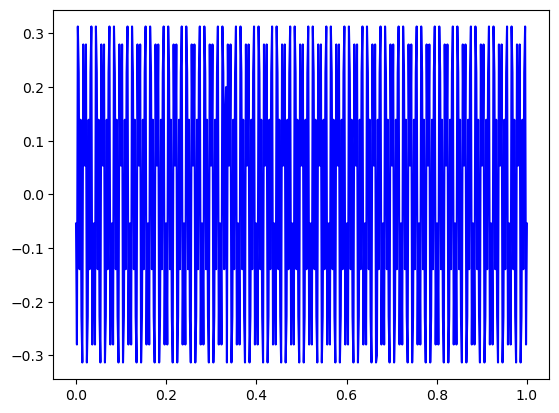

In [8]:
## Initialisations
n=500               #Taille de l'echantillon
t=np.linspace(0,1,n) #On definit un signal sur [0,1]

## Generation du signal
x=np.zeros(n)
tmp=np.zeros(n)
#On ajoute deux cosinus
tmp[350]=4
x+=fft.idct(tmp,norm='ortho')  
tmp=np.zeros(n)
tmp[150]=-3  
x+=fft.idct(tmp,norm='ortho')
#On ajoute deux diracs
x[int(n/3)]=0.2    #Tester 0.5
x[int(2*n/3)]=-0.3 #Tester -1

plt.plot(t,x,'b')
plt.show()
## Mesure du signal
p=20*4       #Nombre de mesures
np.random.seed(42)
A=np.random.randn(p,n) #La matrice de mesure
y=A.dot(x)        #Les mesures

Le code *Generesignal.py* génère un signal discret $x$ qui peut être vu comme une combinaison linéaire de cosinus à différentes fréquences et de diracs. Ce signal n'est pas parcimonieux dans la base canonique des diracs (car il faut à peu près $n$ diracs pour représenter un cosinus) et il n'est pas parcimonieux dans la base des sinus (il faut faire une combinaison linéaire de $n$ cosinus pour représenter un dirac).

Par contre, ce signal est parcimonieux dans un frame qui est l'union de la base canonique et de la base des cosinus. 
Dans ce frame, il suffit en effet de $4$ coefficients non nuls pour reconstruire parfaitement le signal.

<div style="background-color:rgba(0, 0, 255, 0.1); padding:15px;">
On choisira donc le frame représenté par une matrice $\Psi=\begin{pmatrix}I & C \end{pmatrix} \in \mathcal{ M}_{n,2n}(\mathbb{R})$ où $C$ est une base de cosinus à différentes fréquences.
</div>

### 4.1. Implémentation de l'itération proximale

**Q6** Implémentez l'opérateur linéaire $\Psi$ et son adjoint $\Psi^*$. 

Pour $\Psi$, vous vous servirez de la fonction `idct` de Python dans la libraire `scipy.fftpack` qui calcule la transformée en cosinus discret d'un vecteur. Vous ferez attention à préciser `norm='ortho'` dans les options de la `idct` pour que `dct` soit bien l'opération inverse de `idct`.

Pour $\Psi^*$, vous utiliserez le fait que la `idct` est une isométrie quand on précise `norm='ortho'` dans les options de `idct`. C'est-à-dire que `idct` et `dct` sont adjoints.

In [9]:
## Linear function Psi
## (combination of sines and diracs) 
def Psi(alpha) :
    n = int(len(alpha)/2)
    u = fft.idct(alpha[n:], norm='ortho') 
    v = alpha[:n]
    return u+v


## The transpose of Psi
def PsiT(x) : 
    n = len(x)
    alpha = np.zeros(2*n)
    alpha[:n] = x
    alpha[n:] = fft.dct(x, norm='ortho')
    return alpha


n=100
np.random.seed(12)
alpha=np.random.randn(2*n)
x=np.random.randn(n)
print(np.sum(Psi(alpha)*x),'=',np.sum(alpha*PsiT(x)))

-0.25681865786765706 = -0.25681865786765146


Qu'essaye t'on de faire avec le code qui est donné dans les dernières lignes de la cellulle précédente ?

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
Votre réponse ici
</div>

**Q7** Implémentez l'algorithme de calcul du prox de la norme $L^1$. la fonction `prox(alpha,s)` doit calculer le résultat de $\mbox{prox}_{s\|\bullet\|_1}\left(\alpha\right)$.

In [13]:
def prox(alpha,s) :
    beta = np.sign(alpha)*np.maximum(np.abs(alpha) - s, 0)
    return beta

n=2
np.random.seed(12)
alpha=np.random.randn(2*n)

print(prox(alpha,0.1)) # [ 0.37298583 -0.58142588  0.1424395  -1.60073563]
print(prox(alpha,0.3)) # [ 0.17298583 -0.38142588  0.         -1.40073563]
print(Psi(alpha)) # [-0.55818526  0.69260643]


[ 0.37298583 -0.58142588  0.1424395  -1.60073563]
[ 0.17298583 -0.38142588  0.         -1.40073563]
[-0.55818526  0.69260643]


**Q7** Implémentez l'algorithme proximal dans la fonction *RestoreX* avec les notations suivantes:
* `A` est la matrice d'échantillonnage.
* `y` est le vecteur de mesures.
* `sigma` est un paramètre du modèle.
* `nit` est le nombre d'itérations.
* `alpha` est la solution approximative du problème (4).
* `x` est donné par `Psi(alpha)`.
* `CF` est la fonction coût à chaque itération de l'algorithme. 

In [49]:
def cost_function(alpha, sigma, A, y):
    return np.linalg.norm(alpha,1) + sigma/2*np.linalg.norm(A.dot(Psi(alpha))-y,2)**2

def RestoreX(A,y,sigma,nit):
    n = np.shape(A)[1]
    x = np.zeros(n)
    alpha = np.zeros(2*n)
    CF = []
    L = 2*sigma*np.sum(A*A)
    gamma = 1/L
    
    for i in range(nit):
        gradJ = sigma * PsiT((A.T).dot(A@Psi(alpha) - y))
        alpha = prox(alpha - gamma*gradJ, gamma)
        CF.append(cost_function(alpha, sigma, A, y))
    x = Psi(alpha)
    return alpha,x,np.array(CF)


# verification des calculs
alpha,x,CF=RestoreX(A,y,np.pi,3) 
print(alpha.shape,x.shape,CF.shape) # (1000,) (500,) (3,)
print(CF) # [3798.25919421 3689.31263518 3583.86421908]
print(np.allclose(Psi(alpha),x)) # True
print(np.linalg.norm(alpha),np.linalg.norm(x)) # 0.076225839283936 0.10779918933259168

(1000,) (500,) (3,)
[3689.31263518 3583.86421908 3481.79335561]
True
0.061699012732438274 0.08725525669270373


**Q8.** Testez votre algorithme ! Les paramètres `sigma` et `nit` sont à choisir par vous-même (il faut en pratique beaucoup d'itérations pour converger). Vous pourrez observer la façon dont la suite $\alpha^k$ se comporte au fur et à mesure des itérations.

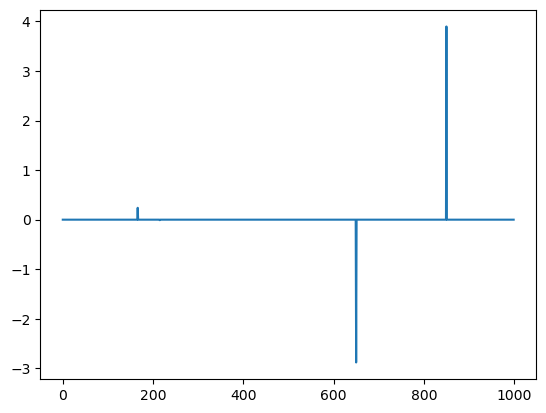

(array([166, 215, 650, 850]),)


In [90]:
sigma=0.1
nit=15000
(alpha,xtilde,CF)=RestoreX(A,y,sigma,nit)
plt.plot(alpha)
plt.show()
l = np.where(alpha != 0)
print(l)

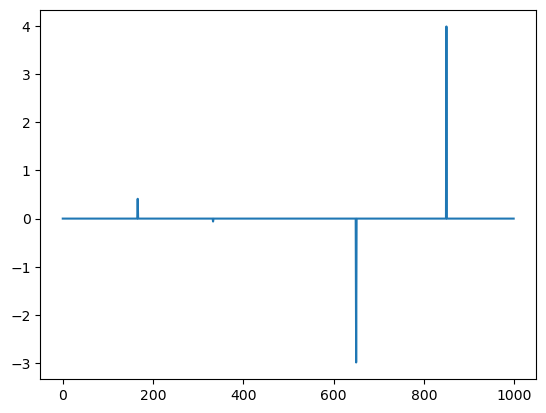

(array([166, 333, 650, 850]),)


In [96]:
sigma=1
nit=200000
(alpha,xtilde,CF)=RestoreX(A,y,sigma,nit)
plt.plot(alpha)
plt.show()
l = np.where(alpha != 0)
print(l)

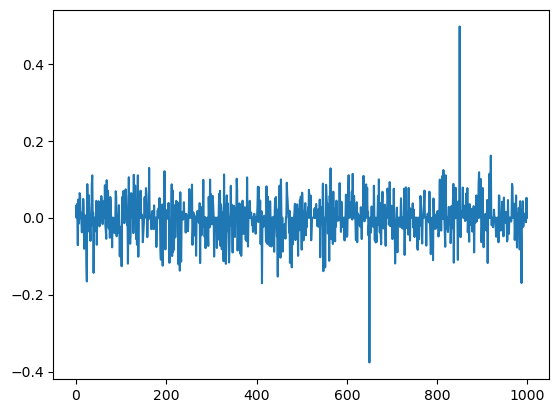

(array([  0,   2,   4,   5,   6,   8,   9,  11,  12,  13,  16,  17,  18,
        19,  20,  22,  23,  24,  25,  27,  28,  29,  31,  32,  34,  35,
        36,  38,  39,  41,  45,  46,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  59,  60,  61,  62,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 107, 109, 110, 111, 112, 113, 114,
       115, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 140, 142, 143, 144, 146,
       148, 149, 150, 152, 154, 155, 156, 157, 158, 160, 161, 162, 163,
       166, 167, 168, 169, 170, 172, 173, 174, 178, 179, 181, 183, 185,
       187, 188, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201,
       204, 205, 206, 207, 208, 209, 210, 212, 213, 214, 215, 216, 217,
       219, 220, 221, 222, 223, 225, 227, 228, 229, 230, 231, 2

In [91]:
sigma=10
nit=20000
(alpha,xtilde,CF)=RestoreX(A,y,sigma,nit)
plt.plot(alpha)
plt.show()
l = np.where(alpha != 0)
print(l)

#### Comments:
On voit que pour $\sigma$ trop petit, on risque de sauter des coefficients non nuls et pour $\sigma$ trop grand , on constate que l'algorithme nécessite beaucoup de temps avant de converger. Donc on choisit $\sigma = 1$. 
On peut aussi facilement voir que les 4 coefficients non nuls sont $166, 333, 650$ et $850$.

**Q9.** Vérifiez que la fonction coût décroit de façon monotone. Quel est le taux de convergence observé ?

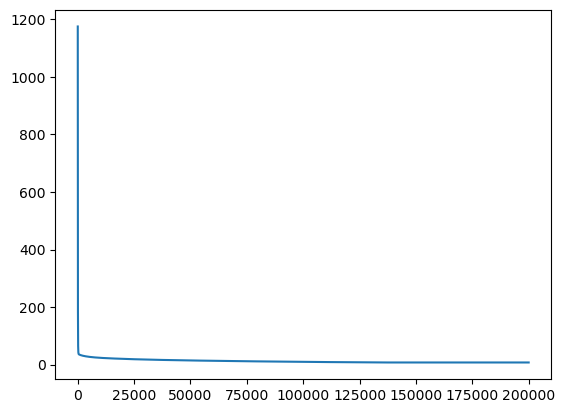

In [97]:
plt.plot(CF)
plt.show()

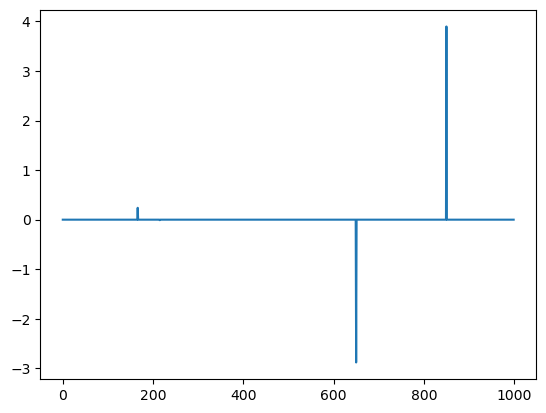

(array([166, 215, 650, 850]),)


In [100]:
sigma=0.1
nit=15000
(alpha,xtilde,CF)=RestoreX(A,y,sigma,nit)
plt.plot(alpha)
plt.show()
l = np.where(alpha != 0)
print(l)

In [101]:
dec = np.zeros(len(CF)-1)
for i in range(len(CF)-1):
    dec[i] = CF[i]-CF[i+1]
print("Minimum value:" + str(min(dec)))

Minimum value:1.2010655860983377e-05


=> La fonction coût décroit de façon monotone.

In [102]:
def convergence_rate(x, L):
    n = len(x[:-1])
    diff = np.abs(x[:-1] - L)
    ratio = diff[1:] / diff[:-1]
    log_ratio = np.log(ratio)
    slope, _ = np.polyfit(np.arange(n-1), log_ratio, 1)
    rate = np.exp(slope)
    return rate

print("Taux de convergence:", round(convergence_rate(CF,CF[-1]), 5))

Taux de convergence: 1.0


<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
Le taux de convergence associé est en o(1/k)
</div>

**Q10.** A partir de combien de mesures pouvez-vous reconstruire exactement le signal $x$ ?

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
On peut construire le signal x à partir de p=45, en effet pour p inférieure à 45 on constate que l'erreur est très importante.
</div>

In [115]:
nit = 200000
n = 500
sigma = 1
p = [80, 45, 30, 20]

A1=np.random.randn(p[0],n) 
y1=A1.dot(x)        
alpha_1,xtilde_1,CF_1 =RestoreX(A1,y1,sigma,nit)

A2=np.random.randn(p[1],n) 
y2=A2.dot(x)        
alpha_2,xtilde_2,CF_2 =RestoreX(A2,y2,sigma,nit)

A3=np.random.randn(p[2],n) 
y3=A3.dot(x)        
alpha_3,xtilde_3,CF_3 =RestoreX(A3,y3,sigma,nit)

A4=np.random.randn(p[3],n) 
y4=A4.dot(x)        
alpha_4,xtilde_4,CF_4 =RestoreX(A4,y4,sigma,nit)

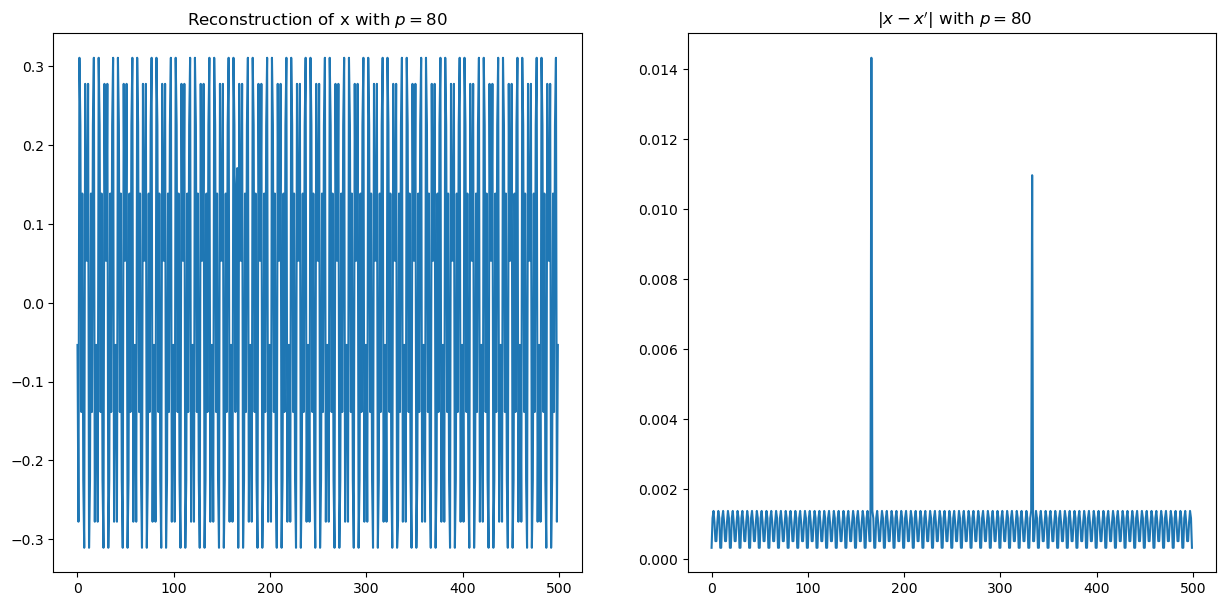

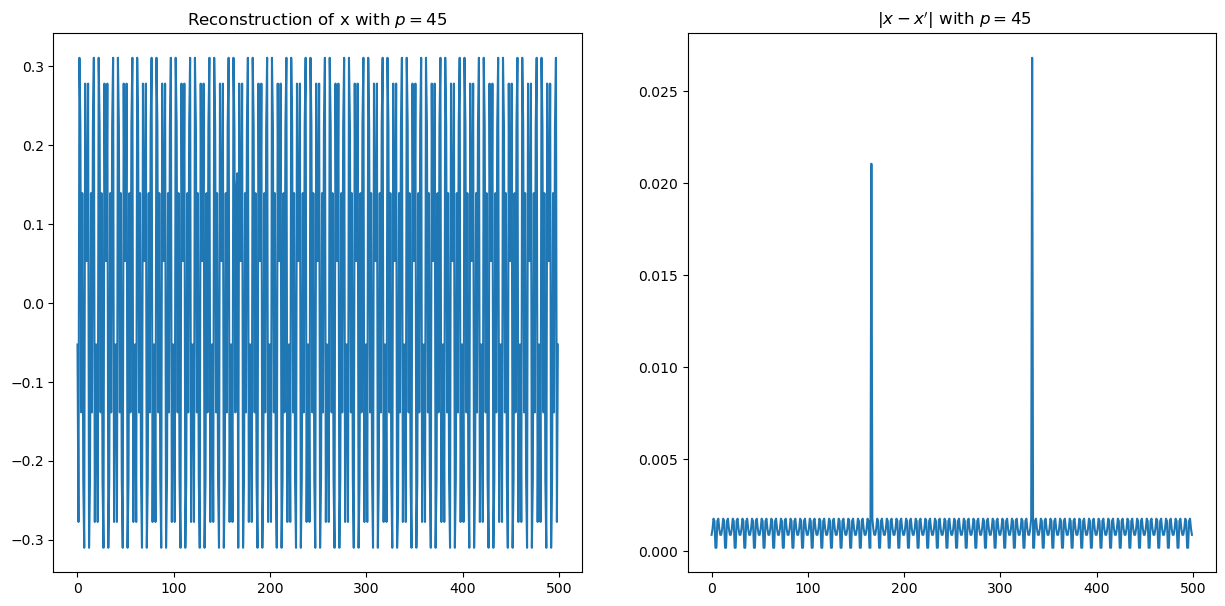

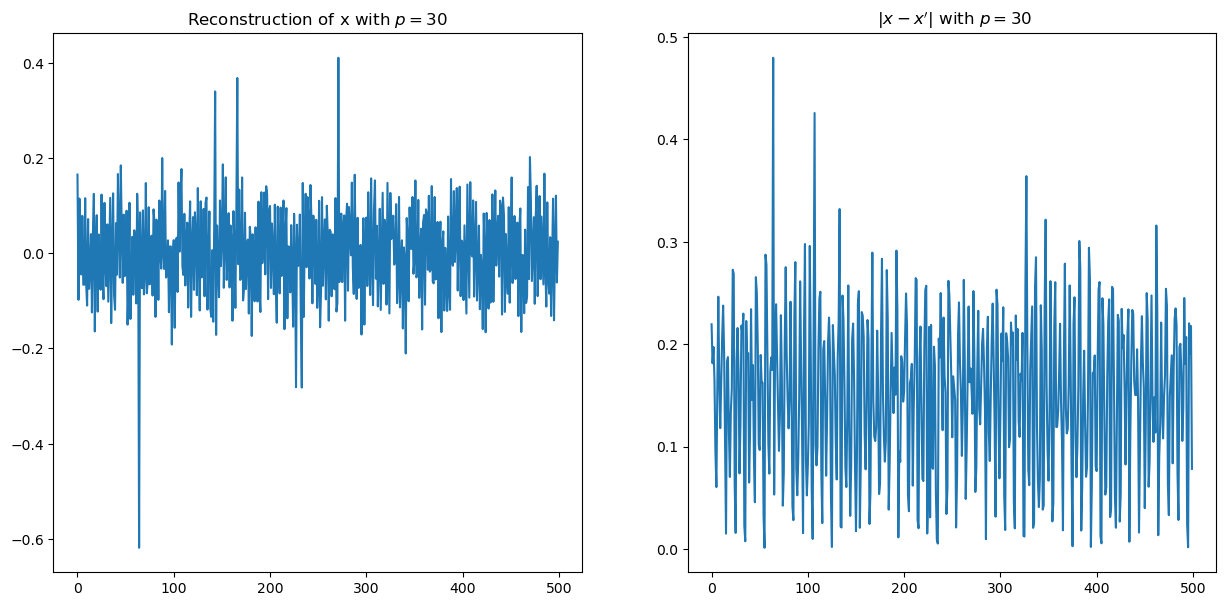

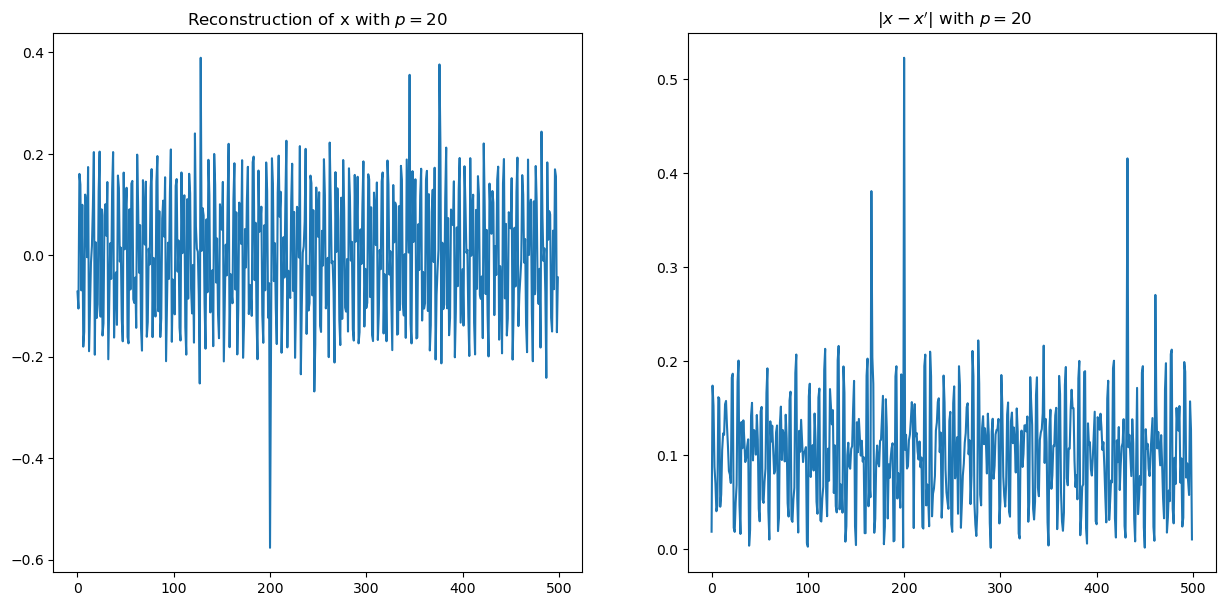

In [116]:
def plotter_2(x, x_tilde, p):
    fig, ax = plt.subplots(1,2, figsize = (15,7))
    ax[0].plot(x_tilde)
    ax[0].set_title("Reconstruction of x with $p = $" + str(p))
    ax[1].plot(np.abs(x-x_tilde))
    ax[1].set_title(" $ |x - x'|$ with $p = $" + str(p))
    plt.show()
    
    
plotter_2(x, xtilde_1, p[0])

plotter_2(x, xtilde_2,  p[1])

plotter_2(x, xtilde_3,  p[2])

plotter_2(x, xtilde_4,  p[3])



### 4.2. Implémentation de l'itération proximale accelérée

On n'a a aucun moment utilisé la convexité de la fonction $J$ pour définir l'algorithme proximal. Celui-ci est de fait sous-optimal et peut être nettement accéléré. Yurii Nesterov a proposé dans les années 1980 plusieurs méthodes permettant l'accélération de la descente de gradient explicite. L'accélération de la descente de gradient proposée Yurii Nesterov en 1984 et adapatée à FB sous le nom de FISTA (Fast Iterative Soft Shrinckage Algorithm) par Beck et Teboulle en 2009 est d'une mise en oeuvre très simple: considérons à nouveau la fonction composite $F=J+\Vert \bullet \Vert_1$ à minimiser. L'algorithme FISTA s'écrit:
<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:15px;font-family:monospace;">
\begin{eqnarray*}
z_k &=& \alpha_k+\beta_k(\alpha_k-\alpha_{k-1})\\
\alpha_{k+1} &=& {\rm prox}_{s\Vert \bullet \Vert_1}(z_k-s\nabla J(\alpha_k))
\end{eqnarray*}
</div>
avec un pas $s\le \frac{1}{L}$ et $\beta_k>0$. On parle de méthode inertielle car cette méthode utilise un terme dit de "mémoire" ou inertiel qui exploite la dernière direction de descente.

Le choix original de Nesterov pour la suite $\beta_k$ est le suivant :
\begin{equation}
\beta_k=\frac{t_k-1}{t_{k+1}}\text{ avec }t_1=1\text{ et }t_{k+1}=\frac{1+\sqrt{1+t_k^2}}{2}
\end{equation}
Pour ce choix on a 
$$F(\alpha_k)-F(\alpha^*)\leqslant \frac{2\Vert \alpha_0-\alpha^*\Vert^2}{sk^2}$$
On peut prendre plus simplement 
<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:15px;font-family:monospace;">
$$\beta_k=\frac{k-1}{k+2}$$
 </div>
 
et dans ce cas, on a $F(\alpha_k)-F(\alpha^*)=o\left(\frac{1}{k^2}\right)$ et on a convergence de la suite $(\alpha_k)_{k\geqslant 1}$. On peut noter que dans ce cas, la première étape est sans inertie ($\beta_1=0$). L'inertie apparait pour le calcul de $\alpha_2$. 

A noter que la suite de terme général $F(\alpha_k)-F(\alpha^*)$ n'est pas nécessairemment décroissante comme dans le cas de FB ou de la descente de gradient. Dans la pratique vous verrez que FISTA est quand même plus rapide que FB.


**Q11.** En vous aidant de ce que vous avez codé dans la partie précédente, implémentez cet algorithme. 

In [77]:
def Nesterov(A,y,sigma,nit):
    n = np.shape(A)[1]
    x = np.zeros(n)
    alpha_p = np.zeros(2*n)
    alpha = np.zeros(2*n)
    CF = np.zeros(nit)
    L = 2*sigma*np.sum(A*A)
    gamma = 1/L
    for i in range(nit):
        tk = (i-1)/(i+2)
        yk = alpha + tk*(alpha - alpha_p)
        gradJ = sigma * PsiT((A.T).dot(A@Psi(yk) - y))
        alpha_p = alpha
        alpha = prox(yk - gamma*gradJ, gamma)
        CF[i] = cost_function(alpha, sigma, A, y)
    x = Psi(alpha)
    return alpha,x,CF


**Q12.** Testez le et comparez la rapidité d'execution de l'algorithme précédent et de celui-ci.

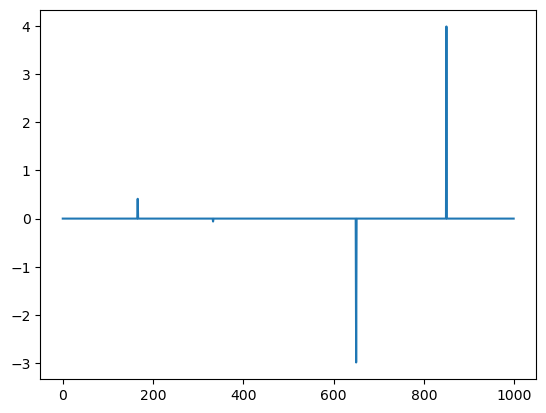

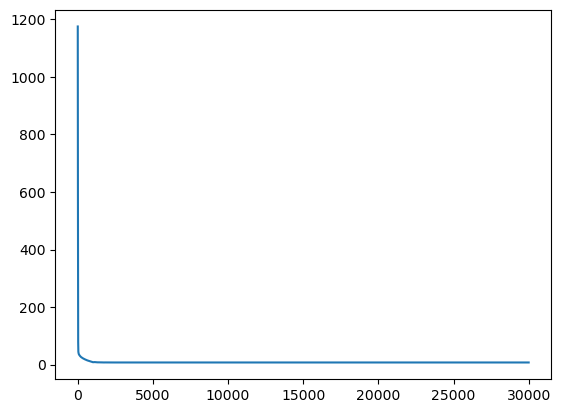

(array([166, 333, 650, 850]),)


In [87]:
nit=30000
sigma=1
(alpha,x,CF)=Nesterov(A,y,sigma,nit)
plt.plot(alpha)
plt.show()
plt.plot(CF)
plt.show()
l = np.where(alpha != 0)
print(l)


**Q13.** Faites un rapide résumé des points qui vous ont semblé les plus importants dans ce TP.

Au cours de ce TP, on a  exploré qu'on peut avec un nombre limité de mesures reconstruire un signal, representer $x$ par ses coefficients $\alpha \in \mathbb{R}^{2n}$ dans une base de cosinus et diraq. On entraîne un algorithme d'optimisation sur les $\alpha$ pour trouver les coefficients $\alpha*$ qui permettent de reconstruire $x$: $x = Psi(\alpha^*)$.On a comparé principalement deux algorithmes : le Forward-Backward Euler et le FISTA. On a trouvé que FISTA est à la fois plus rapide et meilleur pour la reconstruction du signal malgré que les deux méthodes aboutissent aux mêmes résultats.
